In [1]:
import pandas as pd
from collections import Counter
import re
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Fonction pour charger les données
def load_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if '\t' in line:
                text, label = line.strip().split('\t', 1)
                data.append((text, label))
    return data

# Chargement des données
train_data = load_data('../data/train.txt')
print(f"Nombre de tweets chargés: {len(train_data)}")
print("Exemples des 3 premiers tweets:")
for i in range(min(3, len(train_data))):
    print(f"Tweet: {train_data[i][0]}")
    print(f"Étiquette: {train_data[i][1]}")
    print()

# Conversion en DataFrame
train_df = pd.DataFrame(train_data, columns=['text', 'label'])

Nombre de tweets chargés: 7136
Exemples des 3 premiers tweets:
Tweet: Saint-Nazaire se rêve en capitale des #énergies marines renouvelables #electricite http://t.co/nArcLYqxLd
Étiquette: =

Tweet: 4eme Conférence internationale sur le changement climatique et le développement http://t.co/biVoGZVlLj
Étiquette: =

Tweet: Rencontres #windustry 2014 Sascha Wiesner décrit les innovations d'A2SEA dans le transport des éoliennes offshore http://t.co/hPD0DQPay6
Étiquette: =



In [4]:
# Fonction de prétraitement basique adaptée aux n-grammes de caractères
def preprocess_for_char_ngrams(text):
    # Conversion en minuscules
    text = text.lower()
    # Suppression des URLs
    text = re.sub(r'http\S+', '', text)
    # Suppression des mentions
    text = re.sub(r'@\w+', '', text)
    # Conservation de certains caractères spéciaux qui peuvent être informatifs
    # mais suppression des espaces multiples
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Test de prétraitement
sample_text = train_df['text'].iloc[0]
processed_text = preprocess_for_char_ngrams(sample_text)
print(f"Original: {sample_text}")
print(f"Prétraité: {processed_text}")

# Prétraitement de toutes les données
train_df['processed_text'] = train_df['text'].apply(preprocess_for_char_ngrams)

Original: Saint-Nazaire se rêve en capitale des #énergies marines renouvelables #electricite http://t.co/nArcLYqxLd
Prétraité: saint-nazaire se rêve en capitale des #énergies marines renouvelables #electricite


In [5]:
def extract_char_ngrams(text, n=3):
    """
    Extrait les n-grammes de caractères d'un texte.
    
    Args:
        text (str): Le texte à traiter
        n (int): La taille des n-grammes (par défaut 3)
        
    Returns:
        list: Liste des n-grammes extraits
    """
    # Ajouter des espaces au début et à la fin pour capturer les limites de mots
    text = ' ' + text + ' '
    
    # Extraction des n-grammes
    char_ngrams = []
    for i in range(len(text) - n + 1):
        char_ngrams.append(text[i:i+n])
    
    return char_ngrams

# Test d'extraction des n-grammes
sample_text = "écologie"
ngrams = extract_char_ngrams(sample_text, n=3)
print(f"Texte: {sample_text}")
print(f"N-grammes de caractères (n=3): {ngrams}")

Texte: écologie
N-grammes de caractères (n=3): [' éc', 'éco', 'col', 'olo', 'log', 'ogi', 'gie', 'ie ']


In [6]:
def build_char_ngram_vocabulary(df, column='processed_text', n=3):
    """
    Construit le vocabulaire de n-grammes de caractères pour chaque catégorie
    
    Args:
        df (DataFrame): DataFrame contenant les textes et les étiquettes
        column (str): Nom de la colonne contenant les textes prétraités
        n (int): Taille des n-grammes
        
    Returns:
        tuple: Compteurs pour chaque catégorie (positif, négatif, neutre)
    """
    positive_ngrams = Counter()
    negative_ngrams = Counter()
    neutral_ngrams = Counter()
    
    for _, row in df.iterrows():
        # Extraction des n-grammes
        char_ngrams = extract_char_ngrams(row[column], n)
        
        # Mise à jour des compteurs selon la catégorie
        if row['label'] == '+':
            positive_ngrams.update(char_ngrams)
        elif row['label'] == '-':
            negative_ngrams.update(char_ngrams)
        else:  # label == '='
            neutral_ngrams.update(char_ngrams)
    
    return positive_ngrams, negative_ngrams, neutral_ngrams

# Construction des vocabulaires pour différentes tailles de n-grammes
for n in [2, 3, 4]:
    print(f"Construction des vocabulaires pour n-grammes de taille {n}...")
    pos_ngrams, neg_ngrams, neu_ngrams = build_char_ngram_vocabulary(train_df, n=n)
    
    print(f"Top 10 n-grammes positifs (n={n}):")
    print(pos_ngrams.most_common(10))
    
    print(f"\nTop 10 n-grammes négatifs (n={n}):")
    print(neg_ngrams.most_common(10))
    
    print(f"\nTop 10 n-grammes neutres (n={n}):")
    print(neu_ngrams.most_common(10))
    print("\n" + "-"*50 + "\n")

Construction des vocabulaires pour n-grammes de taille 2...
Top 10 n-grammes positifs (n=2):
[('e ', 8582), ('s ', 5385), ('es', 4047), (' d', 3846), (' l', 3779), ('en', 3599), ('le', 3178), ('t ', 2965), ('re', 2556), ('nt', 2391)]

Top 10 n-grammes négatifs (n=2):
[('e ', 6620), ('s ', 4360), ('es', 3323), (' d', 2923), (' l', 2884), ('t ', 2497), ('en', 2492), ('le', 2250), ('de', 1938), (' p', 1844)]

Top 10 n-grammes neutres (n=2):
[('e ', 11206), ('s ', 6883), (' d', 5630), ('es', 5142), ('en', 4520), (' l', 4482), ('le', 3966), ('t ', 3929), ('de', 3524), ('re', 3288)]

--------------------------------------------------

Construction des vocabulaires pour n-grammes de taille 3...
Top 10 n-grammes positifs (n=3):
[('es ', 3046), (' de', 1946), (' le', 1566), ('ent', 1550), ('le ', 1491), ('de ', 1401), ('nt ', 1278), ('re ', 1118), ('les', 1106), ('e d', 1033)]

Top 10 n-grammes négatifs (n=3):
[('es ', 2338), (' de', 1668), (' le', 1244), ('de ', 1167), ('le ', 1088), ('ent', 1

In [7]:
def find_discriminative_ngrams(pos_counter, neg_counter, neu_counter, top_n=100):
    """
    Identifie les n-grammes les plus discriminants pour chaque catégorie
    
    Args:
        pos_counter, neg_counter, neu_counter: Compteurs de chaque catégorie
        top_n (int): Nombre de n-grammes à retenir par catégorie
        
    Returns:
        tuple: Ensembles des n-grammes discriminants pour chaque catégorie
    """
    # Calcul du total de n-grammes par catégorie
    total_pos = sum(pos_counter.values())
    total_neg = sum(neg_counter.values())
    total_neu = sum(neu_counter.values())
    
    # Calcul des scores de discrimination pour les n-grammes positifs
    pos_discriminative = {}
    for ngram, count in pos_counter.items():
        # Calcul du ratio de présence dans la catégorie positive par rapport aux autres
        pos_ratio = count / total_pos if total_pos > 0 else 0
        neg_ratio = neg_counter[ngram] / total_neg if total_neg > 0 else 0
        neu_ratio = neu_counter[ngram] / total_neu if total_neu > 0 else 0
        
        # Score de discrimination (présence dans la catégorie / présence dans les autres)
        discriminative_score = pos_ratio / (neg_ratio + neu_ratio + 0.0001)
        pos_discriminative[ngram] = discriminative_score
    
    # Pour les n-grammes négatifs
    neg_discriminative = {}
    for ngram, count in neg_counter.items():
        neg_ratio = count / total_neg if total_neg > 0 else 0
        pos_ratio = pos_counter[ngram] / total_pos if total_pos > 0 else 0
        neu_ratio = neu_counter[ngram] / total_neu if total_neu > 0 else 0
        
        discriminative_score = neg_ratio / (pos_ratio + neu_ratio + 0.0001)
        neg_discriminative[ngram] = discriminative_score
    
    # Pour les n-grammes neutres
    neu_discriminative = {}
    for ngram, count in neu_counter.items():
        neu_ratio = count / total_neu if total_neu > 0 else 0
        pos_ratio = pos_counter[ngram] / total_pos if total_pos > 0 else 0
        neg_ratio = neg_counter[ngram] / total_neg if total_neg > 0 else 0
        
        discriminative_score = neu_ratio / (pos_ratio + neg_ratio + 0.0001)
        neu_discriminative[ngram] = discriminative_score
    
    # Trier par score de discrimination et prendre les top_n
    top_pos = {ngram for ngram, _ in sorted(pos_discriminative.items(), 
                                           key=lambda x: x[1], reverse=True)[:top_n]}
    top_neg = {ngram for ngram, _ in sorted(neg_discriminative.items(), 
                                           key=lambda x: x[1], reverse=True)[:top_n]}
    top_neu = {ngram for ngram, _ in sorted(neu_discriminative.items(), 
                                           key=lambda x: x[1], reverse=True)[:top_n]}
    
    return top_pos, top_neg, top_neu

# Identification des n-grammes discriminants pour n=3
n = 3
pos_ngrams, neg_ngrams, neu_ngrams = build_char_ngram_vocabulary(train_df, n=n)

disc_pos, disc_neg, disc_neu = find_discriminative_ngrams(pos_ngrams, neg_ngrams, neu_ngrams, top_n=50)

print(f"N-grammes les plus discriminants pour les tweets positifs (n={n}):")
print(list(disc_pos)[:10])

print(f"\nN-grammes les plus discriminants pour les tweets négatifs (n={n}):")
print(list(disc_neg)[:10])

print(f"\nN-grammes les plus discriminants pour les tweets neutres (n={n}):")
print(list(disc_neu)[:10])

N-grammes les plus discriminants pour les tweets positifs (n=3):
['vit', 'opt', ' én', 'ng ', 'ugu', "s'i", 'ner', 'inv', 'ock', 'toc']

N-grammes les plus discriminants pour les tweets négatifs (n=3):
['ge,', 'axe', 'ena', 'auv', 'nad', 'xe ', 'lém', 'uqu', 'roe', 'nd.']

N-grammes les plus discriminants pour les tweets neutres (n=3):
['elo', ' 20', '000', '#jo', 'opp', 'ida', '10 ', 'job', 'rab', ' #j']


In [8]:
def classify_by_char_ngrams(text, disc_pos, disc_neg, disc_neu, n=3):
    """
    Classifie un texte en utilisant les n-grammes de caractères discriminants
    
    Args:
        text (str): Texte à classifier
        disc_pos, disc_neg, disc_neu: Ensembles de n-grammes discriminants
        n (int): Taille des n-grammes
        
    Returns:
        str: Prédiction de la catégorie ('+', '-', ou '=')
    """
    # Prétraitement
    processed = preprocess_for_char_ngrams(text)
    
    # Extraction des n-grammes
    char_ngrams = extract_char_ngrams(processed, n)
    
    # Calcul des scores pour chaque catégorie
    pos_score = sum(1 for ngram in char_ngrams if ngram in disc_pos)
    neg_score = sum(1 for ngram in char_ngrams if ngram in disc_neg)
    neu_score = sum(1 for ngram in char_ngrams if ngram in disc_neu)
    
    # Normalisation par le nombre de n-grammes dans le texte
    if len(char_ngrams) > 0:
        pos_score /= len(char_ngrams)
        neg_score /= len(char_ngrams)
        neu_score /= len(char_ngrams)
    
    # Détermination de la catégorie avec le plus grand score
    scores = {'+': pos_score, '-': neg_score, '=': neu_score}
    
    if all(score == 0 for score in scores.values()):
        return '='  # Par défaut: neutre
    
    return max(scores, key=scores.get)

# Test sur quelques exemples
test_samples = [
    train_df[train_df['label'] == '+']['text'].iloc[0],  # exemple positif
    train_df[train_df['label'] == '-']['text'].iloc[0],  # exemple négatif
    train_df[train_df['label'] == '=']['text'].iloc[0],  # exemple neutre
]

for sample in test_samples:
    pred = classify_by_char_ngrams(sample, disc_pos, disc_neg, disc_neu, n=3)
    print(f"Texte: {sample}")
    print(f"Prédiction: {pred}")
    print()

Texte: Parc #éolien: entente conclut entre Port-Cartier la compagnie Système d'énergie renouvelable Canada: http://t.co/G9DWR1T792 #CoteNord
Prédiction: +

Texte: #Photos :Dans l’Ouest américain,les stigmates d’une sécheresse historique http://t.co/F6As9walnX #Environnement #Climat #EtatsUnis #Ecologie
Prédiction: +

Texte: Saint-Nazaire se rêve en capitale des #énergies marines renouvelables #electricite http://t.co/nArcLYqxLd
Prédiction: +



Évaluation avec n-grammes de caractères de taille 2...
Exactitude (n=2): 0.3886
Nombre de prédictions correctes: 272/700

Évaluation avec n-grammes de caractères de taille 3...
Exactitude (n=3): 0.5057
Nombre de prédictions correctes: 354/700

Évaluation avec n-grammes de caractères de taille 4...
Exactitude (n=4): 0.5357
Nombre de prédictions correctes: 375/700

Évaluation avec n-grammes de caractères de taille 5...
Exactitude (n=5): 0.5586
Nombre de prédictions correctes: 391/700

Meilleure taille de n-grammes: 5 avec une exactitude de 0.5586


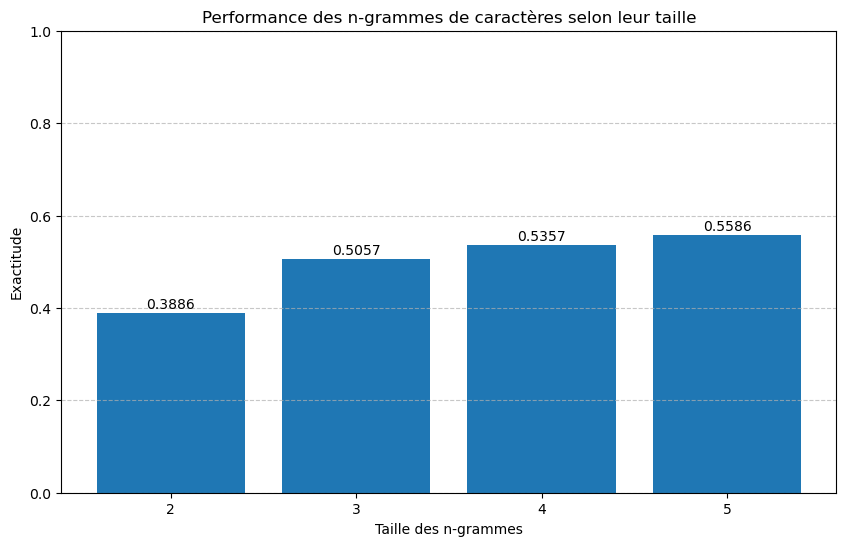

In [9]:
# Chargement des données de développement
dev_data = load_data('../data/dev.txt')
dev_df = pd.DataFrame(dev_data, columns=['text', 'label'])

# Test de différentes tailles de n-grammes
results = {}

for n in [2, 3, 4, 5]:
    print(f"Évaluation avec n-grammes de caractères de taille {n}...")
    
    # Construction des vocabulaires
    pos_ngrams, neg_ngrams, neu_ngrams = build_char_ngram_vocabulary(train_df, n=n)
    
    # Identification des n-grammes discriminants
    disc_pos, disc_neg, disc_neu = find_discriminative_ngrams(pos_ngrams, neg_ngrams, neu_ngrams)
    
    # Classification des données de développement
    predictions = []
    for text in dev_df['text']:
        pred = classify_by_char_ngrams(text, disc_pos, disc_neg, disc_neu, n=n)
        predictions.append(pred)
    
    # Calcul de l'exactitude
    correct = sum(1 for pred, true in zip(predictions, dev_df['label']) if pred == true)
    accuracy = correct / len(dev_df)
    
    results[n] = accuracy
    print(f"Exactitude (n={n}): {accuracy:.4f}")
    print(f"Nombre de prédictions correctes: {correct}/{len(dev_df)}")
    print()

# Affichage des résultats
best_n = max(results, key=results.get)
print(f"Meilleure taille de n-grammes: {best_n} avec une exactitude de {results[best_n]:.4f}")

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values())
plt.xlabel('Taille des n-grammes')
plt.ylabel('Exactitude')
plt.title('Performance des n-grammes de caractères selon leur taille')
plt.ylim(0, 1)
for n, acc in results.items():
    plt.text(n, acc + 0.01, f'{acc:.4f}', ha='center')
plt.xticks(list(results.keys()))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [10]:
# Utilisation de la meilleure taille de n-grammes
best_n = max(results, key=results.get)
print(f"Génération des prédictions finales avec n={best_n}...")

# Construction des vocabulaires avec la meilleure taille
pos_ngrams, neg_ngrams, neu_ngrams = build_char_ngram_vocabulary(train_df, n=best_n)
disc_pos, disc_neg, disc_neu = find_discriminative_ngrams(pos_ngrams, neg_ngrams, neu_ngrams)

# Chargement des données de test
test_data = load_data('../data/test.txt')
test_df = pd.DataFrame(test_data, columns=['text', 'label'])

# Génération des prédictions
test_predictions = []
for text in test_df['text']:
    pred = classify_by_char_ngrams(text, disc_pos, disc_neg, disc_neu, n=best_n)
    test_predictions.append(pred)

# Création du fichier de sortie
output_file = f'char_ngrams_predictions_n{best_n}.txt'
with open(output_file, 'w', encoding='utf-8') as f:
    for (text, _), prediction in zip(test_data, test_predictions):
        f.write(f"{text}\t{prediction}\n")

print(f"Prédictions générées et enregistrées dans '{output_file}'")

Génération des prédictions finales avec n=5...
Prédictions générées et enregistrées dans 'char_ngrams_predictions_n5.txt'
